In [232]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finta import TA
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import jaccard_score
import seaborn as sn
from tabulate import tabulate


In [233]:
WINDOW = 1 # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "60m"  # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
INTERVAL = '1y'     # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
symbol = 'FB'      # Symbol of the desired stock
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'CCI', 'VORTEX']
ROWS_TO_PREDICT = 15

In [234]:
data = yf.download(  # or pdr.get_data_yahoo(...
        tickers = symbol,


        period = INTERVAL,

        interval = FETCH_INTERVAL,

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        # auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-02-04 04:00:00-05:00,205.200000,206.700000,205.200000,206.400000,206.400000,0
2020-02-04 05:00:00-05:00,206.400000,206.440000,206.250000,206.390000,206.390000,0
2020-02-04 06:00:00-05:00,206.180000,206.340000,206.000000,206.340000,206.340000,0
2020-02-04 07:00:00-05:00,206.340000,206.350000,206.000000,206.300000,206.300000,0
2020-02-04 08:00:00-05:00,206.290000,206.500000,204.700000,206.070000,206.070000,0
...,...,...,...,...,...,...
2021-02-03 13:30:00-05:00,268.234985,268.559998,266.950012,267.880005,267.880005,1246802
2021-02-03 14:30:00-05:00,267.869995,268.229889,266.679993,266.779999,266.779999,1244747
2021-02-03 15:30:00-05:00,266.799988,267.959991,266.559998,266.679993,266.679993,1387200


In [235]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
data.head(10)

,open,high,low,close,Adj Close,volume
Datetime,,,,,,
2020-02-04 04:00:00-05:00,205.200000,206.700000,205.200000,206.400000,206.400000,0
2020-02-04 05:00:00-05:00,206.400000,206.440000,206.250000,206.390000,206.390000,0
2020-02-04 06:00:00-05:00,206.180000,206.340000,206.000000,206.340000,206.340000,0
2020-02-04 07:00:00-05:00,206.340000,206.350000,206.000000,206.300000,206.300000,0
2020-02-04 08:00:00-05:00,206.290000,206.500000,204.700000,206.070000,206.070000,0
2020-02-04 09:00:00-05:00,206.010000,206.480000,204.190000,206.270000,206.270000,0
2020-02-04 09:30:00-05:00,206.470001,208.309998,205.202499,207.940002,207.940002,6050902
2020-02-04 10:30:00-05:00,207.950699,208.410004,207.229996,208.110703,208.110703,2213458
2020-02-04 11:30:00-05:00,208.100006,209.550003,208.089996,209.030197,209.030197,1970385


<AxesSubplot:xlabel='Datetime'>

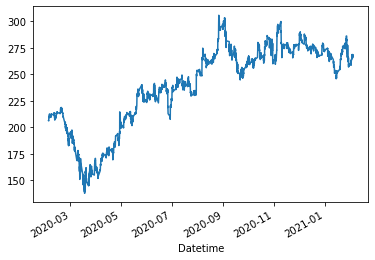

In [236]:
data['close'].plot()

In [237]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = pd.concat([data, ind_data], axis=1)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema15'] = data['close'] / data['close'].ewm(ROWS_TO_PREDICT).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    del (data['volume'])
    del (data['Adj Close'])

    return data

data = _get_indicator_data(data)

In [238]:
data

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,20 period CCI,VIm,VIp,ema50,ema21,ema15,ema5,normVol
Datetime,,,,,,,,,,,,,,,,,,
2020-02-04 04:00:00-05:00,206.400000,NaN,0.000000,0.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN
2020-02-04 05:00:00-05:00,206.390000,0.000000,-0.000224,-0.000125,NaN,0.000000e+00,NaN,NaN,NaN,NaN,66.666667,NaN,NaN,0.999976,0.999976,0.999977,0.999978,NaN
2020-02-04 06:00:00-05:00,206.340000,0.000000,-0.001836,-0.000826,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-1.694915,NaN,NaN,0.999824,0.999827,0.999829,0.999840,NaN
2020-02-04 07:00:00-05:00,206.300000,0.000000,-0.003969,-0.001891,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-9.053498,NaN,NaN,0.999726,0.999731,0.999735,0.999760,NaN
2020-02-04 08:00:00-05:00,206.070000,0.000000,-0.014196,-0.005551,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-153.573377,NaN,NaN,0.998900,0.998919,0.998933,0.999023,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-03 13:30:00-05:00,267.880005,56.740414,0.807584,0.870919,93.377677,7.106224e+09,3.192893,0.080005,46.379635,0.273257,55.323461,0.985011,0.985457,1.003720,1.007169,1.006406,1.002376,0.994326
2021-02-03 14:30:00-05:00,266.779999,51.758043,0.714587,0.839653,87.859074,7.105184e+09,3.066099,-1.700001,41.509313,-0.011244,13.888412,0.990917,1.019685,0.999606,1.002895,1.002131,0.998549,0.993898
2021-02-03 15:30:00-05:00,266.679993,51.316859,0.625604,0.796843,52.984849,7.104082e+09,1.829479,-1.070007,37.162886,-0.418225,6.411374,0.975013,1.649392,0.999246,1.002405,1.001645,0.998479,1.088122


In [239]:
data.columns

Index(['close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', '20 period CCI', 'VIm',
       'VIp', 'ema50', 'ema21', 'ema15', 'ema5', 'normVol'],
      dtype='object')

In [240]:
def create_class_column(row):
    if row['close_shift']-row['close'] > 0.35:
        return 1
    if row['close_shift'] -row['close']< -0.35:
        return -1
    else:
        return 0

In [241]:
data['close_shift'] = data.shift(-WINDOW)['close']
data

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,20 period CCI,VIm,VIp,ema50,ema21,ema15,ema5,normVol,close_shift
Datetime,,,,,,,,,,,,,,,,,,,
2020-02-04 04:00:00-05:00,206.400000,NaN,0.000000,0.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,206.390000
2020-02-04 05:00:00-05:00,206.390000,0.000000,-0.000224,-0.000125,NaN,0.000000e+00,NaN,NaN,NaN,NaN,66.666667,NaN,NaN,0.999976,0.999976,0.999977,0.999978,NaN,206.340000
2020-02-04 06:00:00-05:00,206.340000,0.000000,-0.001836,-0.000826,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-1.694915,NaN,NaN,0.999824,0.999827,0.999829,0.999840,NaN,206.300000
2020-02-04 07:00:00-05:00,206.300000,0.000000,-0.003969,-0.001891,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-9.053498,NaN,NaN,0.999726,0.999731,0.999735,0.999760,NaN,206.070000
2020-02-04 08:00:00-05:00,206.070000,0.000000,-0.014196,-0.005551,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-153.573377,NaN,NaN,0.998900,0.998919,0.998933,0.999023,NaN,206.270000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-03 13:30:00-05:00,267.880005,56.740414,0.807584,0.870919,93.377677,7.106224e+09,3.192893,0.080005,46.379635,0.273257,55.323461,0.985011,0.985457,1.003720,1.007169,1.006406,1.002376,0.994326,266.779999
2021-02-03 14:30:00-05:00,266.779999,51.758043,0.714587,0.839653,87.859074,7.105184e+09,3.066099,-1.700001,41.509313,-0.011244,13.888412,0.990917,1.019685,0.999606,1.002895,1.002131,0.998549,0.993898,266.679993
2021-02-03 15:30:00-05:00,266.679993,51.316859,0.625604,0.796843,52.984849,7.104082e+09,1.829479,-1.070007,37.162886,-0.418225,6.411374,0.975013,1.649392,0.999246,1.002405,1.001645,0.998479,1.088122,266.820000


In [242]:
data['class_column'] = data.apply(create_class_column, axis=1)
data

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,20 period CCI,VIm,VIp,ema50,ema21,ema15,ema5,normVol,close_shift,class_column
Datetime,,,,,,,,,,,,,,,,,,,,
2020-02-04 04:00:00-05:00,206.400000,NaN,0.000000,0.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,206.390000,0
2020-02-04 05:00:00-05:00,206.390000,0.000000,-0.000224,-0.000125,NaN,0.000000e+00,NaN,NaN,NaN,NaN,66.666667,NaN,NaN,0.999976,0.999976,0.999977,0.999978,NaN,206.340000,0
2020-02-04 06:00:00-05:00,206.340000,0.000000,-0.001836,-0.000826,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-1.694915,NaN,NaN,0.999824,0.999827,0.999829,0.999840,NaN,206.300000,0
2020-02-04 07:00:00-05:00,206.300000,0.000000,-0.003969,-0.001891,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-9.053498,NaN,NaN,0.999726,0.999731,0.999735,0.999760,NaN,206.070000,0
2020-02-04 08:00:00-05:00,206.070000,0.000000,-0.014196,-0.005551,NaN,0.000000e+00,NaN,NaN,NaN,NaN,-153.573377,NaN,NaN,0.998900,0.998919,0.998933,0.999023,NaN,206.270000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-03 13:30:00-05:00,267.880005,56.740414,0.807584,0.870919,93.377677,7.106224e+09,3.192893,0.080005,46.379635,0.273257,55.323461,0.985011,0.985457,1.003720,1.007169,1.006406,1.002376,0.994326,266.779999,-1
2021-02-03 14:30:00-05:00,266.779999,51.758043,0.714587,0.839653,87.859074,7.105184e+09,3.066099,-1.700001,41.509313,-0.011244,13.888412,0.990917,1.019685,0.999606,1.002895,1.002131,0.998549,0.993898,266.679993,0
2021-02-03 15:30:00-05:00,266.679993,51.316859,0.625604,0.796843,52.984849,7.104082e+09,1.829479,-1.070007,37.162886,-0.418225,6.411374,0.975013,1.649392,0.999246,1.002405,1.001645,0.998479,1.088122,266.820000,0


In [243]:
# Class divide
data['class_column'].value_counts()

 1    1418
 0    1386
-1    1339
Name: class_column, dtype: int64

In [244]:
del (data['close'])
del (data['close_shift'])
data = data.dropna()
train_set = data.iloc[:-ROWS_TO_PREDICT]
test_set =data.iloc[-ROWS_TO_PREDICT:]

In [245]:
data['class_column'].value_counts()

 1    1392
 0    1345
-1    1327
Name: class_column, dtype: int64

In [246]:
y = data['class_column']
features = [x for x in data.columns if x not in ['class_column']]
x = data[features]

x_train= x.iloc[:-ROWS_TO_PREDICT]
y_train= y.iloc[:-ROWS_TO_PREDICT]
x_test =x.iloc[-ROWS_TO_PREDICT:]
y_test=y.iloc[-ROWS_TO_PREDICT:]

In [247]:
classifiers = dict()

classifiers['DecisionTreeClassifier 1'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='best')
classifiers['DecisionTreeClassifier 2'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='random')
classifiers['DecisionTreeClassifier 3'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='entropy',splitter='best')
classifiers['DecisionTreeClassifier 4'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='entropy',splitter='random')
classifiers['DecisionTreeClassifier 5'] = DecisionTreeClassifier(random_state=0,criterion='gini',splitter='best')
classifiers['DecisionTreeClassifier 6'] = DecisionTreeClassifier(random_state=0,criterion='gini',splitter='random')
classifiers['DecisionTreeClassifier 7'] = DecisionTreeClassifier(random_state=0,criterion='entropy',splitter='best')
classifiers['DecisionTreeClassifier 8'] = DecisionTreeClassifier(random_state=0,criterion='entropy',splitter='random')

classifiers['RandomForestClassifier 1'] = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,criterion='gini')
classifiers['RandomForestClassifier 2'] = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=0,criterion='gini')
classifiers['RandomForestClassifier 3'] = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0,criterion='gini')
classifiers['RandomForestClassifier 4'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,criterion='gini')
classifiers['RandomForestClassifier 5'] = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,criterion='entropy')
classifiers['RandomForestClassifier 6'] = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=0,criterion='entropy')
classifiers['RandomForestClassifier 7'] = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0,criterion='entropy')
classifiers['RandomForestClassifier 8'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,criterion='entropy')

classifiers['GradientBoostingClassifier 1'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
classifiers['GradientBoostingClassifier 2'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.3)
classifiers['GradientBoostingClassifier 3'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.5)
classifiers['GradientBoostingClassifier 4'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=1)
#
classifiers['GradientBoostingClassifier 5'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
classifiers['GradientBoostingClassifier 6'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.3)
classifiers['GradientBoostingClassifier 7'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.5)
classifiers['GradientBoostingClassifier 8'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=1)

classifiers['GradientBoostingClassifier 9'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.1)
classifiers['GradientBoostingClassifier 10'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.3)
classifiers['GradientBoostingClassifier 11'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.5)
classifiers['GradientBoostingClassifier 12'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=1)

In [248]:
def print_conf_matrix(test_y, predict, name):
    matrix = confusion_matrix(test_y, predict,  labels=[-1, 0, 1])
    print(matrix)
    ax= plt.subplot()
    sn.heatmap(matrix, annot=True, ax = ax) #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels', color='white')
    ax.set_ylabel('True labels', color='white')
    ax.set_title(f'Confusion Matrix for {name}' , color='white')
    ax.xaxis.set_ticklabels(['-1','0', '1'], color='white')
    ax.yaxis.set_ticklabels(['-1','0', '1'], color='white')
    plt.show()

def train_model(model,train_x, train_y):
    model.fit(train_x, train_y)

In [249]:
predictions= dict()
score = dict()
for k,v in classifiers.items():
    print("Calculate: ", k)
    train_model(v,x_train,y_train)
    predictions[k] = v.predict(x_test)
    score[k] = accuracy_score(y_test.values, predictions[k])
    print('Score: ',  score[k] )
    # print_conf_matrix(test_y, predictions[k], k)

headers = ["Classifier type", "Accuracy"]
score_df = pd.DataFrame(score.items(), columns=headers)
print(tabulate(score_df, headers, tablefmt="psql"))

Calculate:  DecisionTreeClassifier 1
Score:  0.5333333333333333
Calculate:  DecisionTreeClassifier 2
Score:  0.4
Calculate:  DecisionTreeClassifier 3
Score:  0.4666666666666667
Calculate:  DecisionTreeClassifier 4
Score:  0.4
Calculate:  DecisionTreeClassifier 5
Score:  0.6
Calculate:  DecisionTreeClassifier 6
Score:  0.5333333333333333
Calculate:  DecisionTreeClassifier 7
Score:  0.4
Calculate:  DecisionTreeClassifier 8
Score:  0.5333333333333333
Calculate:  RandomForestClassifier 1
Score:  0.6666666666666666
Calculate:  RandomForestClassifier 2
Score:  0.6666666666666666
Calculate:  RandomForestClassifier 3
Score:  0.5333333333333333
Calculate:  RandomForestClassifier 4
Score:  0.6666666666666666
Calculate:  RandomForestClassifier 5
Score:  0.6666666666666666
Calculate:  RandomForestClassifier 6
Score:  0.6666666666666666
Calculate:  RandomForestClassifier 7
Score:  0.6
Calculate:  RandomForestClassifier 8
Score:  0.6666666666666666
Calculate:  GradientBoostingClassifier 1
Score:  0.